In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jainaru/womens-fashion-image-dataset

Dataset URL: https://www.kaggle.com/datasets/jainaru/womens-fashion-image-dataset
License(s): CC0-1.0
 84% 7.00M/8.33M [00:00<00:00, 72.0MB/s]
100% 8.33M/8.33M [00:00<00:00, 81.8MB/s]


In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile
from PIL import Image
from google.colab.patches import cv2_imshow
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import  Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.spatial.distance import cosine
import pickle

In [ ]:
file_path = "/content/womens-fashion-image-dataset.zip"

with ZipFile(file_path, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:
!ls

 kaggle.json   sample_data  'women fashion'   womens-fashion-image-dataset.zip


In [ ]:
fashion_files = os.listdir("/content/women fashion")
fashion_files[0:5]

['deep burgundy, silky dress with long sleeves and a wrap-style front.jpg',
 'long, flowing dress with a full skirt.jpg',
 'sleeveless dress with a high neckline.jpeg',
 'fitted, short, yellow dress with short sleeves.jpeg',
 'bright red, form-fitting, strapless dress with a high slit on one side revealing part of the leg.jpg']

In [ ]:
print("Number of files in the folder is : ",len(fashion_files))

Number of files in the folder is :  96


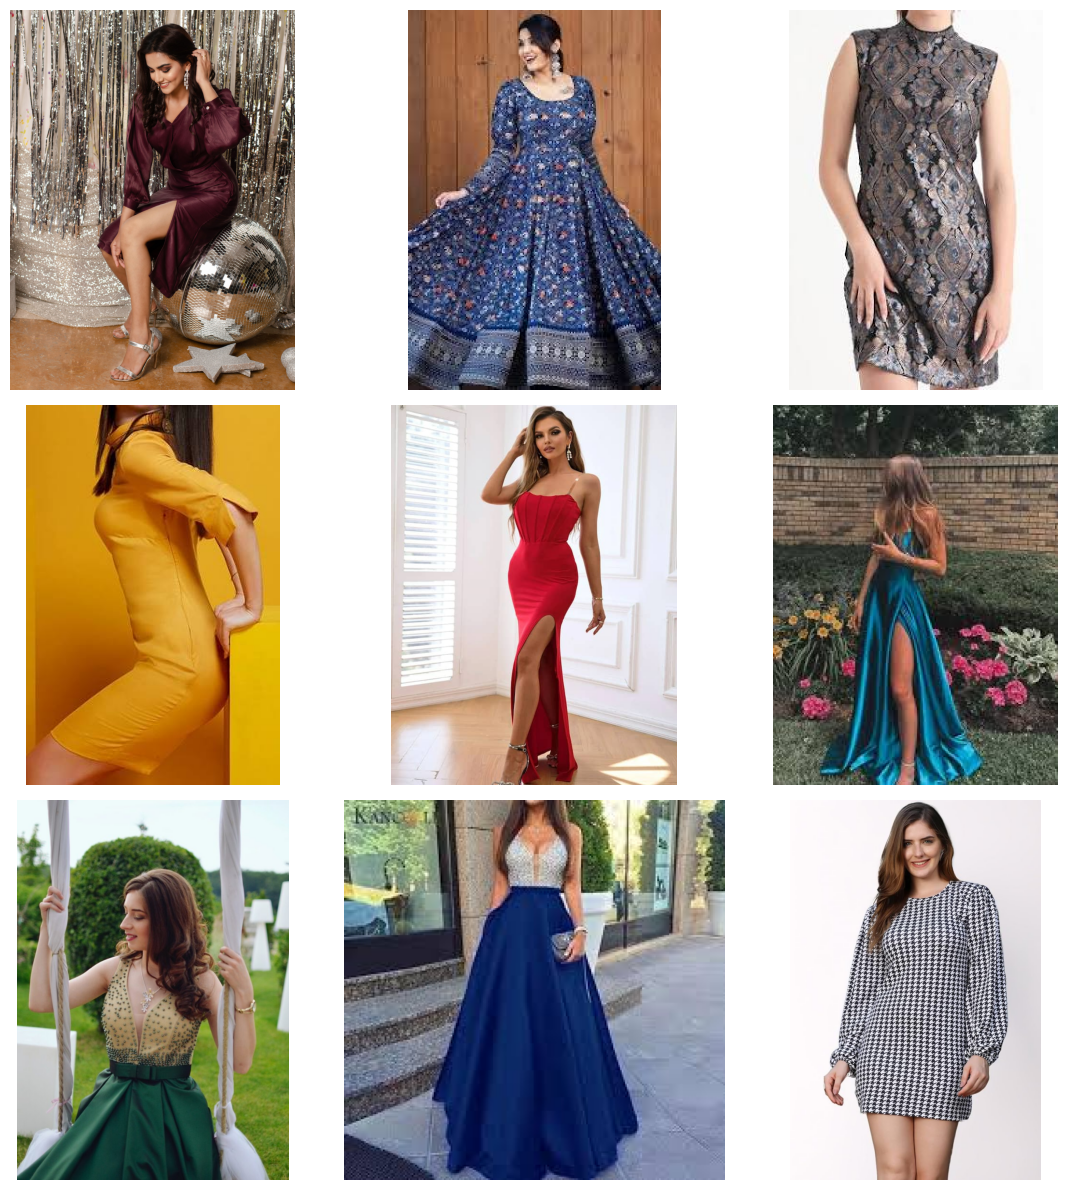

In [ ]:
#lets see the images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
sample_images = fashion_files[:9]
# Loop through the sample images and plot them
for i, image_name in enumerate(sample_images):
    image_path = os.path.join("/content/women fashion", image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()

In [ ]:
def final_files(folder_path):

  """
      This function takes images folder and return files with jpg, png, jpeg, webp format.
  """
  fashion_files = [files for files in os.listdir(folder_path) if files.endswith(('jpg','jpeg','png','webp'))]
  return fashion_files


In [ ]:
print("Number of files in folder before cleaning :",len(fashion_files))
fashion_files = final_files("/content/women fashion")
print("Number of files in folder after cleaning :",len(fashion_files))

Number of files in folder before cleaning : 96
Number of files in folder after cleaning : 96


In [ ]:
def  image_preprocess(folder_path):

  """
      This function takes images folder and return preprocessed images(normalize them resize and convert to array).
  """

  processed_images = []

  for image_name in fashion_files:
    image_path = os.path.join(folder_path, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    image = np.array(image)
    processed_images.append(image)

  return np.array(processed_images)

In [ ]:
final_data = image_preprocess("/content/women fashion")

In [ ]:
final_data

array([[[[0.62352941, 0.56078431, 0.50980392],
         [0.52156863, 0.45490196, 0.37254902],
         [0.77254902, 0.70196078, 0.67058824],
         ...,
         [0.53333333, 0.50588235, 0.47058824],
         [0.55686275, 0.49411765, 0.41960784],
         [0.97254902, 0.97647059, 0.94509804]],

        [[0.55686275, 0.30588235, 0.34509804],
         [0.70980392, 0.51372549, 0.48627451],
         [0.78823529, 0.71764706, 0.6745098 ],
         ...,
         [0.52941176, 0.49019608, 0.45098039],
         [0.53333333, 0.49019608, 0.42745098],
         [0.70980392, 0.69411765, 0.63921569]],

        [[0.61960784, 0.43137255, 0.40784314],
         [0.67843137, 0.3254902 , 0.38431373],
         [0.70196078, 0.21568627, 0.27058824],
         ...,
         [0.78039216, 0.76078431, 0.72156863],
         [0.50588235, 0.44705882, 0.37647059],
         [0.81176471, 0.77647059, 0.74117647]],

        ...,

        [[0.7254902 , 0.49019608, 0.30196078],
         [0.73333333, 0.49411765, 0.30588235]

In [ ]:
#check shape of images
print("Preprocessed images shape:", final_data.shape)

Preprocessed images shape: (96, 224, 224, 3)


In [ ]:
def generate_embeddings(images):
    # Load pre-trained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # Freeze the layers
    for layer in base_model.layers:
        layer.trainable = False
    # Add Flatten layer
    x = Flatten()(base_model.output)
    # Define the model
    model = Model(inputs=base_model.input, outputs=x)
    # Generate embeddings
    embeddings = model.predict(images)
    return embeddings

embeddings = generate_embeddings(final_data)

3/3 [==============================] - 65s 20s/step


1/1 [==============================] - 1s 996ms/step


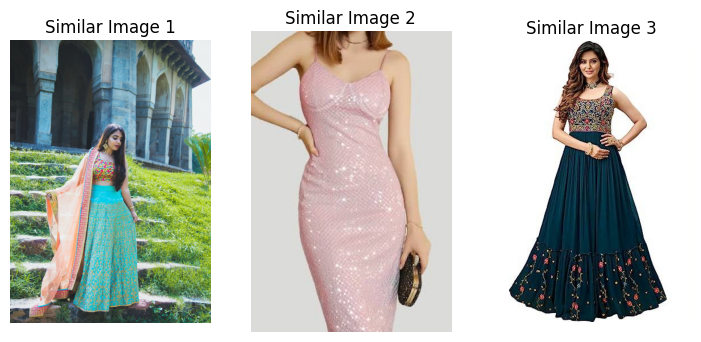

[46, 56, 44]

In [ ]:
def recommendation_system(image_path, embeddings, fashion_files):
    # Check if the image file exists
    if not os.path.isfile(image_path):
        raise ValueError(f"Image file not found: {image_path}")

    # Load the image using OpenCV
    try:
        img = cv2.imread(image_path)
    except cv2.error as e:
        raise Exception(f"Error loading image: {e}")

    # Convert the color space to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess the image
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Generate embeddings for the query image
    query_embedding = generate_embeddings(img)

    # Reshape the query embedding to 1-D
    query_embedding = query_embedding.flatten()

    # Calculate cosine similarity
    similarities = [1 - cosine(query_embedding, embedding.flatten()) for embedding in embeddings]

    # Sort the similarity scores in descending order
    indices = np.argsort(similarities)[::-1]

    # Get the top 5 similar images
    top_indices = indices[:5]

    # Filter out indices that are out of range
    valid_indices = [index for index in top_indices if index < len(fashion_files)]

    # Display similar images
    plt.figure(figsize=(15, 5))
    for i, index in enumerate(valid_indices):
        img_path = fashion_files[index]  # Access directly from the list
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"Similar Image {i+1}")
        plt.axis('off')
    plt.show()

    return valid_indices

# Specify the directory containing fashion images
images_dir = "/content/women fashion"


# Call the recommendation_system() function with the fashion_files variable
recommendation_system("/content/women fashion/Anarkali suit with fitted bodice with a high neckline.jpg", embeddings, fashion_files)


In [ ]:
#dump the recommnendation model
with open("fashion_recommendation_system.pkl","wb") as f:
  pickle.dump(recommendation_system,f)

# dump the embedding
with open("embeddings.pkl", "wb") as f:
    pickle.dump(embeddings, f)